# Exploring ECHO Data in Your Area
This workbook is a way to quickly view data from EPA's Enforcement and Compliance History Online portal that is relevant just to your area.
It is designed to work with the [ECHO Exporter](https://echo.epa.gov/tools/data-downloads#exporter) file (download as ZIP file and extract to CSV).

Input your zip code into the text box below, then click the "Run" button to see data for your region!

In [1]:
# Not currently using this section, it's a way to make this page into more of an app/less of a data science notebook

# # Widgets for defined interaction
# import ipywidgets as widgets
# from IPython.display import display
# w = widgets.Text("53703")
# display(w)

In [2]:
# my_zip = w.value

my_zip = "98296"
data_location = "data/ECHO_EXPORTER.csv" # Where the ECHO data is saved on your computer in relation to this file

# Below this point, everything is calculated automatically

You don't need to interact with it in order to get it to work, but if you want to dive deeper, you can use it to get started exploring!

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

In [4]:
# Define columns of interest (see the echo_exporter_columns xlsx file that comes bundled with the csv download)
# This is not a comprehensive list of columns; more are available.
# This dictionary maps the column titles to their data types, to allow for faster import

# Note to self - right now mapping everything not explicitly a number as a string, might be an issue later
column_mapping = {
    "REGISTRY_ID": str,
    "FAC_NAME": str,
    "FAC_ZIP": str,
    "FAC_LAT": float,
    "FAC_LONG": float,
    "FAC_QTRS_WITH_NC": float,
    "CAA_PERMIT_TYPES": str,
    "CWA_PERMIT_TYPES": str,
    "RCRA_PERMIT_TYPES": str,
    "FAC_3YR_COMPLIANCE_HISTORY": str,
    "FAC_INSPECTION_COUNT": float,
    "GHG_CO2_RELEASES": float
}
# not currently using: "FAC_INFORMAL_COUNT", "FAC_FORMAL_ACTION_COUNT"

In [5]:
# Get the data
echo_data = pd.read_csv(data_location, usecols = list(column_mapping.keys()), dtype=column_mapping)

## How many facilities in your zip code are tracked in the ECHO database?

In [6]:
# Filter to just your zip code
my_echo = echo_data[echo_data["FAC_ZIP"] == my_zip]

num_facilities = my_echo.shape[0]
print("There are %s facilities in %s tracked in the ECHO database." %(num_facilities, my_zip))

There are 59 facilities in 98296 tracked in the ECHO database.


In [7]:
# Let's show a quick map of your area and the facilities in it

def mapper(dataframe):
    # Initialize the map
    m = folium.Map(
        location = [my_echo.mean()["FAC_LAT"], my_echo.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in dataframe.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"]
        ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_my_area = mapper(my_echo)
map_of_facilities_in_my_area

## What permit types have been issued in this zip code?
This would be a good place to explain what these permits are used for, what's covered in ECHO and what isn't.

What are the limits on these permits– what are they allowing to be emitted?

CAA_PERMIT_TYPES      4
CWA_PERMIT_TYPES     39
RCRA_PERMIT_TYPES    18
dtype: int64


Text(0.5, 1.0, 'Number of Permits of Various Types in 98296')

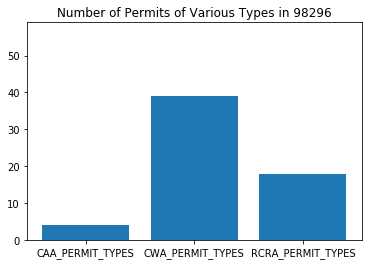

In [8]:
permit_cols = ["CAA_PERMIT_TYPES","CWA_PERMIT_TYPES","RCRA_PERMIT_TYPES"]

# Get a DataFrame with just the columns relating to permit type
permits = my_echo[permit_cols]
# Count how many non-null values are in each column
counted_permit_types = permits.count()

# Print how many values are present for each column (permitting law)
print(counted_permit_types)

# Graph the number of permits by which law they correspond to
plt.bar(counted_permit_types.keys(), counted_permit_types)
plt.ylim(top = num_facilities) # so the top of the graph is the total # of facilities in the region
plt.title("Number of Permits of Various Types in %s" %(my_zip))

CAA_PERMIT_TYPES
{'Minor Emissions': 3, 'Major Emissions': 1}


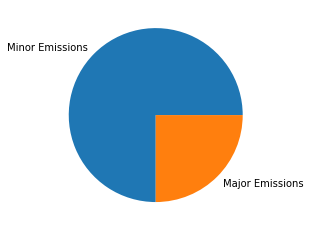

CWA_PERMIT_TYPES
{'Minor': 39}


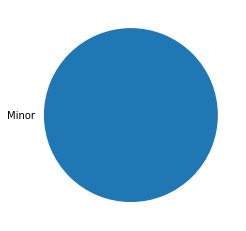

RCRA_PERMIT_TYPES
{'LQG': 2, 'Other': 13, 'VSQG': 2, 'Other, VSQG': 1}


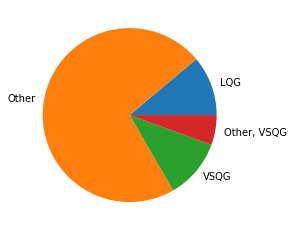

In [9]:
# Drilling down into what types of permits have been issued

# Define a function for counting permit types
def count_permits(permit_law):
    # Find all the possible permit types
    permit_types_with_nan = my_echo[permit_law].unique().tolist()
    # Remove null value as a permit type
    permit_types = [i for i in permit_types_with_nan if str(i) != "nan"] # note that nan values fail to be counted even when left in
    # Define a dictionary to save counted permits
    permits_issued = {}
    # For each permit type...
    for permit_type in permit_types:
        # Count those unique values and save them corresponding to their permit type
        permits_issued[permit_type] = my_echo[my_echo[permit_law] == permit_type].shape[0]
    # Return a tuple naming the law the permit is issued under and a dictionary counting its issued permits
    return (permits_issued)

# For each permit type
for permit_law in permit_cols:
    counted_permits = count_permits(permit_law)
    
    # Print the raw data
    print(permit_law)
    print(counted_permits)
    
    # Plot a pie chart breaking down type of permit in each category
    plt.pie(counted_permits.values(), labels = list(counted_permits.keys()))
    plt.show()


### This would be a good place to add context: what's a major vs. minor CAA permit? What is LQG or VSQG– or for that matter, what's RCRA?

Explanation goes here

## Are the facilities in my region in compliance with their permits?

A bit more detail: what is compliance vs. noncompliance? Does this mean they're currently exceeding their permits, that they usually do, that they have recently?

Text(0.5, 1.0, '25 of 59 Total Facilities Noncompliant in 98296 in the last 12 qtrs')

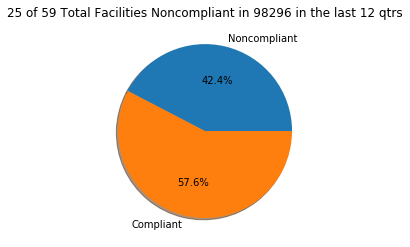

In [10]:
# How many facilities have been out of compliance in the last 12 quarters?

noncompliant = my_echo[my_echo["FAC_QTRS_WITH_NC"] > 0].sort_values(by="FAC_QTRS_WITH_NC", ascending=False)
num_noncompliant = noncompliant.shape[0]
plt.pie([num_noncompliant, num_facilities - num_noncompliant], labels=["Noncompliant", "Compliant"], autopct='%1.1f%%', shadow=True)

plt.title("%s of %s Total Facilities Noncompliant in %s in the last 12 qtrs" %(num_noncompliant, num_facilities, my_zip))

### Where are these noncompliant facilities?

In [11]:
map_of_noncompliant_facilities = mapper(noncompliant)
map_of_noncompliant_facilities

### Which facilities are out of compliance?

In [12]:
# Which facilities aren't in compliance?

print("Facilities in %s noncompliant in the last 12 quarters:" %my_zip)
cols_for_print = ["FAC_NAME", "FAC_QTRS_WITH_NC", "FAC_3YR_COMPLIANCE_HISTORY", "FAC_INSPECTION_COUNT"]
cols_for_print.extend(permit_cols)
print(noncompliant[cols_for_print])

Facilities in 98296 noncompliant in the last 12 quarters:
                                         FAC_NAME  FAC_QTRS_WITH_NC  \
1218630                              TOPSOILS INC              12.0   
746041                      RIVERSIDE TOPSOIL INC              12.0   
2079972                             ASPEN HILLS 2              10.0   
282862                 APPLIANCE RECYCLING OUTLET              10.0   
1135180             SEATTLE SNOHOMISH MILL CO INC              10.0   
31064        QUINNS CROSSING RURAL CLUSTER SUBDIV               8.0   
1848482              MALTBY CONTAINER & RECYCLING               8.0   
1529060   35TH AVE SE CORRIDOR IMPROVEMENT RC1628               8.0   
119656                          SEATTLE HILL ROAD               7.0   
1765873  FALES ROAD SNOHOMISH COUNTY FIRE STATION               7.0   
1292533         NORTH WOODINVILLE INDUSTRIAL PARK               7.0   
2006803                               35TH AVE SE               6.0   
1325478            

# Greenhouse Gases

Text(0.5, 1.0, 'Of the 59 facilities reporting to ECHO in 98296, 2 report greenhouse gas emissions.')

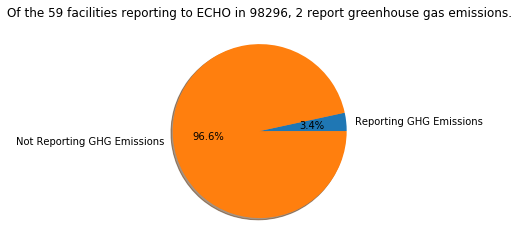

In [13]:
my_ghg = my_echo[my_echo["GHG_CO2_RELEASES"].notna()]

plt.pie([my_ghg.shape[0], num_facilities - my_ghg.shape[0]], labels=["Reporting GHG Emissions", "Not Reporting GHG Emissions"], autopct='%1.1f%%', shadow=True)

plt.title('Of the %s facilities reporting to ECHO in %s, %s report greenhouse gas emissions.' %(num_facilities, my_zip, my_ghg.shape[0]))


Stats on CO2 releases for the facilities that are reporting: Total Facility Emissions in metric tons CO2e (excluding Biogenic CO2) from the most recent reporting year.

In [17]:
print("'Count' is the number of facilities reporting; all of the other numbers are statistics on the greenhouse gas emissions of all of the facilities in %s, measured in metric tons of CO2e." %my_zip)
my_ghg["GHG_CO2_RELEASES"].describe()

'Count' is the number of facilities reporting; all of the other numbers are statistics on the greenhouse gas emissions of all of the facilities in 98296, measured in metric tons of CO2e.


count        2.000000
mean     36429.500000
std      19277.852175
min      22798.000000
25%      29613.750000
50%      36429.500000
75%      43245.250000
max      50061.000000
Name: GHG_CO2_RELEASES, dtype: float64

**Bonus:** Try entering the mean (from above) into https://www.epa.gov/energy/greenhouse-gas-equivalencies-calculator and see what an average facility in your zip code emits into the atmosphere compared to you.

Text(0, 0.5, 'metric tons CO2e (excluding Biogenic CO2)')

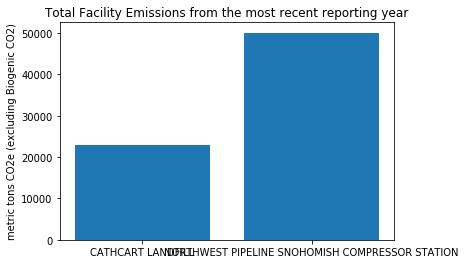

In [15]:
plt.bar(my_ghg["FAC_NAME"], my_ghg["GHG_CO2_RELEASES"])
plt.title("Total Facility Emissions from the most recent reporting year")
plt.ylabel("metric tons CO2e (excluding Biogenic CO2)")

# Next questions
* What are the top 3 noncompliant facilities in the zip code and what are they violating?
* Which types of noncompliance are we experiencing here?
* Beyond "significant" – how much over their permits are they?
